In [1]:
import re
import sys
import copy
import logging
import inspect
import operator
import textwrap
import itertools
import numpy as np
import functools as ft

# --- IMPORT SOME UTILS FROM GLOBUTILS
from globutils import (get_reducer, propagate_err, alphanumeric_sort,
                       getfloat_key, getfloat_attr, gformat)

In [2]:
# --- Configure logging once, ideally at the start of your program ---
format='%(message)s'   # only show the message itself
format='%(levelname)s | %(message)s'
format='%(levelname)s: %(message)s'
# format='%(asctime)s | %(levelname)s | %(message)s'
# format='%(asctime)s | %(levelname)s | %(name)s | %(funcName)s | %(message)s'
datefmt=None
# datefmt='%Y-%m-%d %H:%M:%S'
logging.basicConfig(
    level=logging.INFO,
    format=format,
    datefmt=datefmt,
)
logger = logging.getLogger(__name__)

# # --- Example: log CPU count ---
# CPU_COUNT = os.cpu_count()
# logger.info(f'The number of CPUs: {CPU_COUNT}')

In [3]:
# --- The package lmfit is a MUST
try:
    import lmfit
except ImportError:
    msg =  f'lmfit is required but not installed. Please install it with `pip install lmfit`...'
    logger.error(msg)
    raise ImportError(msg)

try:
    import matplotlib 
    _HAS_MATPLOTLIB = True
except Exception:
    _HAS_MATPLOTLIB = False
    
try:
    import numdifftools 
    HAS_NUMDIFFTOOLS = True
except ImportError:
    HAS_NUMDIFFTOOLS = False


try:
    from tqdm import tqdm
    _HAS_TQDM = True
except Exception:
    _HAS_TQDM = False


try:
    from sklearn.metrics import r2_score as rsq
except ImportError:
    from globutils import r2_score_util as rsq


def _ensureMatplotlib(function):
    if _HAS_MATPLOTLIB:
        @ft.wraps(function)
        def wrapper(*args, **kws):
            return function(*args, **kws)
        return wrapper

    def no_op(*args, **kwargs):
        print('matplotlib module is required for plotting the results')
    return no_op

In [4]:
class LmfitGlobal:
    _valid_connectors = ('+', '-', '*', '/')
    _valid_connectors_dict = {
        '+': operator.add,
        '-': operator.sub,
        '*': operator.mul,
        '/': operator.truediv,
    }


    @staticmethod
    def evaluate_function(func, x, params, prefix, i, func_kws=None):
        """Evaluate a single function with parameters from lmfit and `func` keyward arguments (if any).

        Args:
            func (callable): The function to evaluate
            x (array, list of floats): Array-like of x data
            params (lmfit.Parameters): Contains the Parameters for the model.
            prefix (str): Prefix for the function `func` (e.g. 'c0_', 'c1_').
            i (int): Index for dataset (e.g. 0 for first dataset).
            func_kws (dict, optional): Additional keyword arguments to pass to model function. 
                Defaults to None.

        Returns:
            ndarray: Evaluated function `func` values.
        """
        if func_kws is None:
            func_kws = {}

        x = np.array(x)

        # --- Get ordered function parameters ---
        fn_pars = list(inspect.signature(func).parameters.keys())
        argnames = fn_pars[1:]  # skip first (x variable)

        kwargs = {}
        for name in argnames:
            param_key = f'{prefix}{name}_{i}'
            if param_key in params:
                kwargs[name] = params[param_key].value
            elif name in func_kws:
                kwargs[name] = func_kws[name]
            # else: leave default
            else:
                pass # IS THIS OKAY!?

        return func(x, **kwargs)
    
    
    ### apply_operators  # --- OLD NAME ---
    @staticmethod
    def reduce_with_operators(items, ops, operator_map):
        """Reduce a sequence of items into a composite using operators.

        Args:
            items (list): Sequence of items to combine.
            ops (list of str): Operators of length len(items)-1.
            operator_map (dict): Mapping of operator symbols to functions (e.g. {'+': operator.add}).

        Returns:
            obj (object): Composite result after applying operators.
        """
        obj = ft.reduce(
            lambda x, y: operator_map[y[1]](x, y[0]),
            zip(items[1:], ops),
            items[0]
            )
        return obj
    

    # @staticmethod
    # def _format_callable(func):
    #     """Return a string like 'func(arg1, arg2, ...)' for a callable."""
    #     sig = inspect.signature(func)
    #     args = ', '.join(sig.parameters.keys())
    #     return f'{func.__name__}({args})'


    @staticmethod
    def build_expression(funcs, operators):
        """Build a human-readable expression string from functions and operators.

        Args:
            funcs (list): list of callable functions to describe 
                (e.g., lmfit.Model.func or any callable).
            operators (list of str): Operators ('+', '-', '*', '/') of length len(funcs)-1.

        Returns:
            expr (str): String representation of the composite function with arguments.
        """
        # if len(operators) != len(funcs) - 1:
        #     raise ValueError('operators must have length len(funcs)-1')

        def _format_callable(func):
            """Return a string like 'func(arg1, arg2, ...)' for a callable."""
            sig = inspect.signature(func)
            args = ', '.join(sig.parameters.keys())
            return f'{func.__name__}({args})'
    
        parts = []
        for func, op in itertools.zip_longest(funcs, operators, fillvalue=''):
            parts.append(_format_callable(func))
            if op:
                parts.append(op)

        return ' '.join(parts)

    @staticmethod
    def pretty_expr(expr, line_style="#", width=80):
        """Log a boxed expression using logger.info(), similar to print_in_box() above.

        Args:
            expr (str): The expression string to display.
            line_style (str, optional):  Character(s) used for the box border default to '#'.
            width (int, optional): Maximum width of the box default to 80.
        """
        # Wrap text to fit inside the box
        wrapped = textwrap.wrap(expr, width=width - 4)

        # Determine box width
        box_width = max(len(line) for line in wrapped) + 4

        # Top border
        logger.info(line_style * box_width)

        # Middle lines
        for line in wrapped:
            logger.info(f"{line_style} {line.ljust(box_width - 4)} {line_style}")

        # Bottom border
        logger.info(line_style * box_width)

   
    @staticmethod
    def correl_table(params):
        """Return a printable correlation table for a Parameters object."""
        varnames = [vname for vname in params if params[vname].vary]
        nwid = max(8, max([len(vname) for vname in varnames])) + 1

        def sfmt(a):
            return f" {a:{nwid}s}"

        def ffmt(a):
            return sfmt(f"{a:+.4f}")

        title = ['', sfmt('Variable')]
        title.extend([sfmt(vname) for vname in varnames])

        title = '|'.join(title) + '|'
        bar = [''] + ['-'*(nwid+1) for i in range(len(varnames)+1)] + ['']
        bar = '+'.join(bar)

        buff = [bar, title, bar]

        for vname, par in params.items():
            if not par.vary:
                continue
            line = ['', sfmt(vname)]
            for vother in varnames:
                if vother == vname:
                    line.append(ffmt(1))
                elif vother in par.correl:
                    line.append(ffmt(par.correl[vother]))
                else:
                    line.append('unknown')
            buff.append('|'.join(line) + '|')
        buff.append(bar)
        return '\n'.join(buff)


    @staticmethod
    def lmfit_report(
            inpars, 
            r2_dict=None,
            modelpars=None, 
            show_correl=True, 
            min_correl=0.1,
            sort_pars=False, 
            correl_mode='list'
            ):
        """Generate a report of the fitting results.

        The report contains the best-fit values for the parameters and their
        uncertainties and correlations.

        Args:
            inpars (lmfit.Parameters): Input Parameters from fit or MinimizerResult returned from a fit.
            r2_dict (dict, optional): Dictionary of calculated coefficient of determinations.
            modelpars (lmfit.Parameters, optional): Known Model Parameters.
            show_correl (bool, optional): Whether to show list of sorted correlations (default is True).
            min_correl (float, optional): Smallest correlation in absolute value to show (default is 0.1).
            sort_pars (bool or callable, optional): Whether to show parameter names sorted in alphanumerical order. 
                If False (default), then the parameters will be listed in the order they were added to the Parameters 
                dictionary. If callable, then this (one argument) function is used to extract a comparison key from each list element.
            correl_mode ({'list', table'} str, optional): Mode for how to show correlations. Can be either 'list' (default) to show a 
                sorted (if ``sort_pars`` is True) list of correlation values, or 'table' to show a complete, formatted table of correlations.

        Returns:
            str: Multi-line text of fit report.
        """
        def correl_table(params):
            """Return a printable correlation table for a Parameters object."""
            varnames = [vname for vname in params if params[vname].vary]
            nwid = max(8, max([len(vname) for vname in varnames])) + 1

            def sfmt(a):
                return f" {a:{nwid}s}"

            def ffmt(a):
                return sfmt(f"{a:+.4f}")

            title = ['', sfmt('Variable')]
            title.extend([sfmt(vname) for vname in varnames])

            title = '|'.join(title) + '|'
            bar = [''] + ['-'*(nwid+1) for i in range(len(varnames)+1)] + ['']
            bar = '+'.join(bar)

            buff = [bar, title, bar]

            for vname, par in params.items():
                if not par.vary:
                    continue
                line = ['', sfmt(vname)]
                for vother in varnames:
                    if vother == vname:
                        line.append(ffmt(1))
                    elif vother in par.correl:
                        line.append(ffmt(par.correl[vother]))
                    else:
                        line.append('unknown')
                buff.append('|'.join(line) + '|')
            buff.append(bar)
            return '\n'.join(buff)
    
        inpars = copy.deepcopy(inpars) # MAKE OWN COPY
        
        if isinstance(inpars, lmfit.Parameters):
            result, params = None, inpars
        if hasattr(inpars, 'params'):
            result = inpars
            params = inpars.params


        if sort_pars:
            if callable(sort_pars):
                key = sort_pars
            else:
                key = alphanumeric_sort
            parnames = sorted(params, key=key)
        else:
            # dict.keys() returns a KeysView in py3, and they're indexed
            # further down
            parnames = list(params.keys())

        if r2_dict is None:
            r2_dict = {}

        buff = []
        add = buff.append
        namelen = max(len(n) for n in parnames)
        if result is not None:
            add("[[Fit Statistics]]")
            add(f"    # fitting method   = {result.method}")
            add(f"    # function evals   = {getfloat_attr(result, 'nfev')}")
            add(f"    # data points      = {getfloat_attr(result, 'ndata')}")
            add(f"    # variables        = {getfloat_attr(result, 'nvarys')}")
            add(f"    chi-square         = {getfloat_attr(result, 'chisqr')}")
            add(f"    reduced chi-square = {getfloat_attr(result, 'redchi')}")
            add(f"    Akaike info crit   = {getfloat_attr(result, 'aic')}")
            add(f"    Bayesian info crit = {getfloat_attr(result, 'bic')}")
            if hasattr(result, 'rsquared'):
                add(f"    R-squared          = {getfloat_attr(result, 'rsquared')}")
            else:  ## ADD THIS PART
                mean_val = r2_dict.get('mean', None)
                weighted_val = r2_dict.get('weighted', None)
                # Only proceed if at least one value is not None
                if mean_val is not None and weighted_val is not None:
                    tol = 1e-12
                    if abs(mean_val - weighted_val) < tol:
                        add(f"    R-squared          = {getfloat_key(r2_dict, 'mean')}")
                    else:
                        add(f"    R-squared (mean)   = {getfloat_key(r2_dict, 'mean')}")
                        add(f"    R-squared (weight) = {getfloat_key(r2_dict, 'weighted')}")
                elif mean_val is not None:
                    add(f"    R-squared (mean)   = {getfloat_key(r2_dict, 'mean')}")
                elif weighted_val is not None:
                    # add(f"    R-squared (weighted) = {getfloat_key(r2_dict, 'weighted')}")
                    # add(f"    R-squared (var)    = {getfloat_key(r2_dict, 'weighted')}")
                    add(f"    R-squared (weight) = {getfloat_key(r2_dict, 'weighted')}")
                # else: both None → do nothing (no add)
                
            if not result.errorbars:
                add("##  Warning: uncertainties could not be estimated:")
                if result.method in ('leastsq', 'least_squares') or HAS_NUMDIFFTOOLS:
                    parnames_varying = [par for par in result.params
                                        if result.params[par].vary]
                    for name in parnames_varying:
                        par = params[name]
                        space = ' '*(namelen-len(name))
                        if par.init_value and np.allclose(par.value, par.init_value):
                            add(f'    {name}:{space}  at initial value')
                        if (np.allclose(par.value, par.min) or np.allclose(par.value, par.max)):
                            add(f'    {name}:{space}  at boundary')
                else:
                    add("    this fitting method does not natively calculate uncertainties")
                    add("    and numdifftools is not installed for lmfit to do this. Use")
                    add("    `pip install numdifftools` for lmfit to estimate uncertainties")
                    add("    with this fitting method.")

        add("[[Variables]]")
        for name in parnames:
            par = params[name]
            space = ' '*(namelen-len(name))
            nout = f"{name}:{space}"
            inval = '(init = ?)'
            if par.init_value is not None:
                inval = f'(init = {par.init_value:.7g})'
            if modelpars is not None and name in modelpars:
                inval = f'{inval}, model_value = {modelpars[name].value:.7g}'
            try:
                sval = gformat(par.value)
            except (TypeError, ValueError):
                sval = ' Non Numeric Value?'
            if par.stderr is not None:
                serr = gformat(par.stderr)
                try:
                    spercent = f'({abs(par.stderr/par.value):.2%})'
                except ZeroDivisionError:
                    spercent = ''
                sval = f'{sval} +/-{serr} {spercent}'

            if par.vary:
                add(f"    {nout} {sval} {inval}")
            elif par.expr is not None:
                add(f"    {nout} {sval} == '{par.expr}'")
            else:
                add(f"    {nout} {par.value: .7g} (fixed)")

        if show_correl and correl_mode.startswith('tab'):
            add('[[Correlations]] ')
            for line in correl_table(params).split('\n'):
                buff.append('  %s' % line)
        elif show_correl:
            correls = {}
            for i, name in enumerate(parnames):
                par = params[name]
                if not par.vary:
                    continue
                if hasattr(par, 'correl') and par.correl is not None:
                    for name2 in parnames[i+1:]:
                        if (name != name2 and name2 in par.correl and
                                abs(par.correl[name2]) > min_correl):
                            correls[f"{name}, {name2}"] = par.correl[name2]

            sort_correl = sorted(correls.items(), key=lambda it: abs(it[1]))
            sort_correl.reverse()
            if len(sort_correl) > 0:
                add('[[Correlations]] (unreported correlations are < '
                    f'{min_correl:.3f})')
                maxlen = max(len(k) for k in list(correls.keys()))
            for name, val in sort_correl:
                lspace = max(0, maxlen - len(name))
                add(f"    C({name}){(' '*30)[:lspace]} = {val:+.4f}")
        return '\n'.join(buff)
    
 
    @staticmethod
    def wrap_model_reprstring(expr, width=80, indent=4):
        """Wrap a composite model expression string at operators for readability.

        Args:
            expr (str): The composite model expression string.
            width (int, optional): Max line width (default is 80).
            indent (int, optional): Spaces to indent continuation lines (default is 4)

        Returns:
            str: Wrapped expression string.
        """
        tokens = re.split(r'(\+|\-|\*|/)', expr)  # split but keep operators
        lines = []
        current = ""

        for tok in tokens:
            if len(current) + len(tok) + 1 > width:
                lines.append(current.rstrip())
                current = " " * indent + tok
            else:
                current += tok
        if current:
            lines.append(current.rstrip())

        return "\n".join(lines)



    def __init__(self, items, independent_vars=None, nan_policy='raise', method='leastsq', **fit_kws):
        """
        Create lmfit-global function from user-supplied model function.

        Args:
            items (dict) : Dictionary defining the model problem. Here is the how it is define
                - 'data' : dict
                    Defines the experimental data to be fitted, formatted as, 
                        {'xy': np.column_stack([x, y_1, y_2, ...]), 'xrange': None}

                    * 'xy' a 2-D array with columns [x, y_1, y_2, ...].
                    * 'xrange' can specify a domain restriction (or None) for fitting range [NOT SURE HERE].

                - 'functions' : dict
                    Defines the theoretical model functions and how they are combined.
                    Must contain:
                        'theory' : list of dicts
                            Each dict specifies one function with:
                                - 'func_name' : callable
                                    The model function (e.g., gaussian, exponential).
                                - 'init_params' : dict
                                    Initial parameter guesses. Each parameter is itself
                                    a dict with keys like 'value', 'vary', 'min', 'max'.
                                - 'fixed_opts' : dict
                                    Non-fit options (e.g., constants).
                                - 'func_kws' : dict 
                                    Additional keyword arguments to pass to model function `'func_name'`.
                                    Default to {}

                        'theory_connectors' : list of str
                            Binary operators ('+', '-', '*', '/') defining how to
                            combine the functions in 'theory'. Length must be one less
                            than the number of theory functions. For example:
                                ['+', '*'] means theory[0] + theory[1] * theory[2].

            independent_vars (:obj:`list` of :obj:`str`, optional) :  Explicit names of independent variables 
                for the model `function` (default is None).
            nan_policy ({'raise', 'propagate', 'omit'}, optional) : How to handle NaN or missing values in the data.
                - `'raise'` : raise a `ValueError` (default)
                - `'propagate'` : do nothing
                - `'omit'` : drop missing data
            method (str, optional) : Fitting method available in lmfit (default is 'leastsq')
            prefix (str, optional) : Prefix used for the model. Default will be created with index [NOT SURE NEEDED].
            **fit_kws (dict, optional) : Additional options to pass to the minimizer being used..

        Notes:
        - 
        - 
        - 
        """
        # --- Make own copy to avoid overwriting of internal elements ---
        items = copy.deepcopy(items)
        # for key, val in kws.items():
        #     setattr(self, key, val)
 
        self.items = items
        self.method = method
        self.fit_kws = fit_kws
        self.nan_policy = nan_policy
        self.independent_vars = independent_vars

        # --- Define Data attributes ---
        self.data_x, self.data_y = None, None
        self.xdat, self.ydat = None, None
        self.data_xrange = None 
        self.has_nan = False

        # --- Define Function attributes ---
        self.nc = None
        self._prefix_on = False
        self.theory_connectors = None
        
        # --- Validate inputs ---
        self._validate_data()
        self._validate_functions()
        self._validate_nan_policy()


        # --- Containers to build model ---
        self.models = []
        self.prefixes = []
        self.func_kws_all = []   # list of dict: Additional keyword arguments to pass to model function (IF ANY).
        self.functions_used = []
        self.function_names = []
        self.composite_model = []
        # self.fixed_options_all = [] # REMOVED (replaced with self.kws_all)
        self.independent_vars_all = []
        

        # --- Build initial parameters ---
        self.initial_params = lmfit.Parameters()


        # --- Initiate fitting program ---
        self.rss = []
        self.r2 = {}
        self.r2_dict = {}
        self.r2_raw = None
        self.r2_mean = None
        self.r2_weighted = None
        self.fit_success = False
        # self._eval()
        # logger.info(f'Evaluating lmfit fitting/minimization protocols for the functions...')
        # logger.info(f'Setting lmfit fitting/minimization protocols for the functions...')

        # --- setup: create model and initialize parameters ---
        self.setup()
        
        # --- print model functions expressions ---
        self.funcs_expr = self.build_expression(funcs=self.functions_used, operators=self.theory_connectors)
        self.funcs_expr = f'y(x;) = {self.funcs_expr}'
        self.pretty_expr(self.funcs_expr, line_style='#', width=80)  # LOGGER VERSION
        # print_in_box(self.funcs_expr, line_style='#', width=80)      # PRINT VERSION




    def setup(self):
        """Prepare models and initialize parameters for fitting."""
        self._create_models()
        self._initialize_parameters()
        self._build_composite_model()
        self._eval()
        # self._eval_init()
        # logger.info(f'Evaluating lmfit fitting/minimization protocols for the functions...')
        logger.info(f'Setting lmfit fitting/minimization protocols for the functions...')

    # -------------------------------
    # Properties
    # -------------------------------
    @property
    def prefix_on(self):
        return self._prefix_on

    @prefix_on.setter
    def prefix_on(self, value):
        if not isinstance(value, bool):
            raise TypeError("prefix_on must be a boolean")
        self._prefix_on = value

    def __repr__(self):
        return (
            f'LmfitGlobal(N={self.N}, ny={self.ny}, nc={self.nc}, '
            f'nan_policy="{self.nan_policy}", prefix_on={self._prefix_on}, '
            f'expr="{self.funcs_expr}") '
            )
    
    
    # -------------------------------
    # Validation helpers
    # -------------------------------
    def _validate_data(self):
        """Extract and validate data info."""
        data_dict = self.items.get('data', None)
        if data_dict is None:
            raise ValueError('Raw data needed for fit')

        self.data_dict = data_dict
        self.data_xy = self.data_dict.get('xy', None)
        if self.data_xy is None:
            raise ValueError('Raw x-y data needed for fit')

        arr = np.asarray(self.data_xy)
        if arr.ndim != 2:
            raise ValueError('We expect x-y data to be a 2D array')

        self.data_x = arr[:, 0]
        self.data_y = arr[:, 1:]
        # --- extract number of dataset ny and length N of each dataset
        self.N, self.ny = self.data_y.shape

        # ---- Fit range [NOT SURE II SHOULD COME HERE! PERHAPS IN FUNCTION] ----
        self.data_xrange = self.data_dict.get('xrange', None)
        self.xdat, self.ydat = self.data_x, self.data_y

        # if self.data_xrange:
        #     if not isinstance(self.data_xrange, (list, tuple)) or len(self.data_xrange) != 2:
        #         raise ValueError("`data_xrange` must be a list/tuple of two numbers")
        #     minval, maxval = self.data_xrange
        #     idx = np.where((self.data_x >= minval) & (self.data_x <= maxval))[0]
        #     self.xdat = np.take(self.data_x, idx)
        #     self.ydat = np.take(self.data_y, idx, axis=0)

        if self.data_xrange is not None:
            if not self.data_xrange:  # catches [], (), '', 0, False
                raise ValueError(f'`data_xrange` cannot be empty')
            if (
                not isinstance(self.data_xrange, (list, tuple)) or len(self.data_xrange)!=2 or 
                not all(isinstance(xr, (int, float)) for xr in self.data_xrange)
            ):
                raise ValueError(
                    f'`data_xrange` must be a list/tuple of two numbers, got: {self.data_xrange}'
                    ) 
        if self.data_xrange:
            minval, maxval = self.data_xrange
            idx = np.where((self.data_x >= minval) & (self.data_x <= maxval))[0]
            # ---- Safety check: ensure we found at least one index ---
            if idx.size == 0:
                raise ValueError(
                    'No data points found in the specified range {self.data_xrange}. '
                    'Please check your input range or data.'
                )
            # --- Apply the index selection
            self.xdat = np.take(self.data_x, idx)          # the range data we are interested to fit
            self.ydat = np.take(self.data_y, idx, axis=0)  # the range data we are interested to fit
        logger.info(f'Validating data...')


    def _validate_functions(self):
        """Extract and validate theory/functions info."""
        func_dict = self.items.get('functions', None)
        if func_dict is None:
            raise ValueError('Theory/Functions needed for fit')

        self.func_dict = func_dict
        self.theory_dict = self.func_dict.get('theory', None)
        if self.theory_dict is None:
            raise ValueError('Fit Functions (`theory`) are required for fitting')

        self.nc = len(self.theory_dict)
        self.theory_connectors = self.func_dict.get('theory_connectors', None)

        if self.nc > 1:
            self._prefix_on = True
            if self.theory_connectors is None:
                raise ValueError('Missing `theory_connectors` list — required for multiple theory functions')
            if not isinstance(self.theory_connectors, list):
                raise TypeError('`theory_connectors` must be a list')
            if not all(isinstance(op, str) and op in self._valid_connectors for op in self.theory_connectors):
                raise ValueError(f'`theory_connectors` must contain only {self._valid_connectors}')
            if len(self.theory_connectors) != self.nc - 1:
                raise ValueError(f'Expected {self.nc - 1} connectors for {self.nc} theory functions')
            # Precompile operator functions
            self.connectors = [self._valid_connectors_dict[op] for op in self.theory_connectors]
        else:
            self._prefix_on = False
            if self.theory_connectors not in (None, [], ()):
                raise ValueError('`theory_connectors` must be None or empty when only one theory function is provided')
        logger.info(f'Validating functions...')


    # def _validate_nan_policy(self):
    #     """Check NaN policy and handle accordingly."""
    #     self.has_nan = np.isnan(self.ydat).any()
    #     if self.has_nan:
    #         if self.nan_policy == 'raise':
    #             raise ValueError(
    #                 'Detected NaN values in `ydat`, but `nan_policy="raise"` is active.\n'
    #                 'Please clean your data or choose a different nan_policy:\n'
    #                 '  - "omit"      -> exclude NaN-containing points\n'
    #                 '  - "propagate" -> allow NaNs to pass through\n'
    #                 '  - "raise"     -> stop and alert (default)'
    #             )
    #         elif self.nan_policy == 'omit':
    #             mask = ~np.isnan(self.ydat).any(axis=1)
    #             self.xdat = self.xdat[mask]
    #             self.ydat = self.ydat[mask]
    #         elif self.nan_policy == 'propagate':
    #             pass  # leave NaNs in place
    #         else:
    #             raise ValueError('Invalid nan_policy: {self.nan_policy}')
    #     logger.info(f'Validating functions...')
            

    def _validate_nan_policy(self):
        """Check NaN Policy and Handle accordingly"""
        # -- Check of the the raw data to fit has NaNs
        self.has_nan = np.isnan(self.ydat).any()
        # -- Raise error if NaNs are found and policy is 'raise'
        if self.has_nan and self.nan_policy == 'raise':
            raise ValueError(
                f'Detected NaN values in `ydat`, but `nan_policy="raise"` is active.\n'
                'Please clean your data or choose a different `nan_policy`:\n'
                '  - "omit"      -> automatically exclude NaN-containing points from the fit\n'
                '  - "propagate" -> allow NaNs to pass through (may result in NaN outputs)\n'
                '  - "raise"     -> (default) stop and alert if any NaNs are present'
            )
        logger.info(f'Validating nan policy...')


    # -------------------------------
    # Creating Model(s) Functions
    # -------------------------------
    def _create_models(self):
        """
        Create lmfit.Model objects for each theory entry.

        Builds a list of models, their function names, prefixes, and independent
        variables. Parameter hints are applied from `init_params`, and fixed options
        are stored separately for later use.
        """
        # # --- Reset containers to avoid stale state ---
        # self.functions_used = []
        # self.function_names = []
        # self.prefixes = []
        # self.independent_vars_all = []
        # self.fixed_options_all = []
        # self.models = []

        for i, entry in enumerate(self.theory_dict):
            func = entry.get('func_name')
            if func is None or not callable(func):
                raise ValueError(
                    f'Missing or invalid `"func_name"` in theory_dict[{i}] — must be a callable.'
                )
            self.functions_used.append(func)
            self.function_names.append(func.__name__)

            init_params = entry.get('init_params')
            if init_params is None:
                raise ValueError(f'Missing `"init_params"` for function `{func.__name__}`')

            # fixed_opts = entry.get('fixed_opts', {}) # REMOVED (replaced with func_kws)
            func_kws = entry.get('func_kws', {})

            # --- Get ordered function parameters ---
            fn_pars = list(inspect.signature(func).parameters.keys())
            xpar = fn_pars[:1]  # first argument is EXPECTED to 'x'
             # --- Tell lmfit which arguments are independent variables like `fixed_opts` ---
            # indep_vars = xpar + list(fixed_opts.keys()) # REMOVED (replaced with func_kws)
            indep_vars = xpar + list(func_kws.keys())

            # --- Prefix for multi-component models ----
            prefix = f'c{i}_' if self.prefix_on else f''
            self.prefixes.append(prefix)

            # --- Build lmfit.Model ---
            # model = lmfit.Model(func, prefix=prefix)
            model = lmfit.Model(func, independent_vars=indep_vars, prefix=prefix)
            self.independent_vars_all.append(indep_vars)

            # --- Apply parameter hints for fit parameters ---
            for pname, hint in init_params.items():
                model.set_param_hint(pname, **hint)

            # --- Store the fixed options so we can pass them later ---
            model.func_kws = func_kws # NOT A GOOD IDEA
            # Store fixed options separately
            # self.fixed_options_all.append(fixed_opts) # REMOVED (replaced with self.func_kws_all)
            self.func_kws_all.append(func_kws)
            self.models.append(model)
        logger.info(f'Creating lmfit.Models for the functions...')


    def _initialize_parameters(self):
        """
        Initialize lmfit.Parameters for all datasets and models.

        Each dataset gets its own parameter set, with names suffixed by the dataset index.
        """
        # # --- Rest parameter
        # self.initial_params = lmfit.Parameters()

        for iy in range(self.ny):  # loop over datasets
            for model in self.models:  # loop over models
                initpar = model.make_params()
                for name, par_dict in initpar.items():
                    pname = f"{name}_{iy}"  # dataset-specific suffix
                    self.initial_params.add(
                        pname,
                        value=par_dict.value,
                        vary=par_dict.vary,
                        min=par_dict.min,
                        max=par_dict.max,
                    )
        logger.info(f'Initializing lmfit.Parameters for the functions...')
        # # --- print model functions expressions ---
        # self.funcs_expr = self.build_expression(funcs=self.functions_used, operators=self.theory_connectors)
        # self.funcs_expr = f'y(x;) = {self.funcs_expr}'
        # print_in_box(self.funcs_expr, line_style='#', width=80)
    

    def _build_composite_model(self):
        """Build a composite similar to lmfit.CompositeModel from a list of models and operators
        to connect the models in the list.
        """
        models = self.models
        operators = self.theory_connectors
        operator_map = self._valid_connectors_dict

        self.composite_model = self.reduce_with_operators(
            items=models, 
            ops=operators, 
            operator_map=operator_map
            )


    def _evaluate_models(self, xdat, params, i):
        """Evaluate all models for a given dataset index `i` and combine them
        using the theory connectors.

        Args:
            xdat (array, list of floats): Array-like of x data, xdat.
            params (lmfit.Parameters): Parameter set containing values for all model components.
            i (int): Dataset index specifying which column of y-data to evaluate.

        Returns:
        r (nd.array): The combined model output for the given dataset index,
            constructed by applying the operators in `self.theory_connectors`
            to the individual model results.
        """

        results = []
        models = self.models
        operators = self.theory_connectors
        operator_map = self._valid_connectors_dict
        for midx, model in enumerate(models):
            y = self.evaluate_function(
                func=model.func,
                x=xdat,
                params=params,
                # prefix=self.prefixes[midx],
                prefix=model.prefix,       # cleaner
                i=i,
                # func_kws=self.func_kws_all[midx],
                func_kws=model.func_kws,   # self-contained
            )
            results.append(y)

        # Combine results using operators
        r = self.reduce_with_operators(
            items=results,
            ops=operators, 
            operator_map=operator_map
        )
        return r
    
    # -------------------------------
    # Parameters Helpers
    # -------------------------------
    def _set_global_params(self, *parlist):
        """INTERNAL IMPLEMENTATIONS
        Tie one or more parameters to a single master parameter, making them global (shared).

        This method ties all indexed variants of a parameter (e.g. "sigma_0", "sigma_1", ...)
        to a single master parameter. The master parameter retains its original `vary` flag
        (free or fixed) as defined in `self.initial_params`. All dependent parameters are
        set with `expr=master_name` so they share the master’s value.

        Args:
            *parlist (str | list[str] | lmfit.Parameter | lmfit.Parameters | sequence):
                Parameter(s) to globalize. Supported forms include:
                  - A single parameter name string (e.g. "sigma_0")
                  - A list of parameter name strings
                  - An `lmfit.Parameters` object (all keys will be globalized)
                  - A sequence of `(name, Parameter)` tuples (e.g. `params.items()`)
                  - A sequence of `Parameter` instances
                  - Multiple arguments (e.g. `_set_global_params(p1, p2, "sigma_0")`)

        Raises:
            ValueError: If a supplied parameter name or master parameter is not found
                        in `self.initial_params`.
            TypeError: If `parlist` contains unsupported types.

        Notes:
            - The master parameter’s `expr` is cleared to ensure independence.
            - The master’s `vary` flag is restored to its original state after tying.
            - If the master is fixed (`vary=False`), all tied parameters will also be fixed.
            - Logging is used to inform about globalizing actions and warnings.

        Examples:
            >>> # Example 1: single string
            >>> LmfitGlobal._set_global_params("sigma_0")

            >>> # Example 2: list of strings
            >>> LmfitGlobal._set_global_params(["center_1"])   # list of str
            >>> LmfitGlobal._set_global_params(["center_1", "amplitude_0"])  # list of str
        
            >>> # Example 3: lmfit.Parameter object
            >>> from lmfit import Parameter
            >>> par1 = Parameter("sigma_0", 0.25)   # single par
            >>> LmfitGlobal._set_global_params(par1)
            >>> par1 = Parameter("sigma_0", 0.25)   # single par
            >>> par2 = Parameter("center_0", 0.25)  # single par
            >>> LmfitGlobal._set_global_params(par1, par2)

            >>> # Example 4: lmfit.Parameters object
            >>> from lmfit import Parameters
            >>> params = Parameters()
            >>> params.add("sigma_0", value=0.25, vary=True)
            >>> params.add("sigma_1", value=0.25, vary=False)
            >>> LmfitGlobal._set_global_params(params)

            >>> # Example 5: sequence of Parameter instances
            >>> from lmfit import Parameter
            >>> p1 = Parameter("sigma_0", value=0.25, vary=True)
            >>> p2 = Parameter("sigma_1", value=0.25, vary=False)
            >>> LmfitGlobal._set_global_params([p1, p2])

            >>> # Example 6: sequence of (name, Parameter) tuples
            >>> LmfitGlobal._set_global_params(list(params.keys()))
        """
        # --- normalize input into names ---
        names = []
        for par in parlist:
            if isinstance(par, str):
                names.append(par)
            elif isinstance(par, lmfit.Parameters):
                names.extend(list(par.keys()))
            elif isinstance(par, lmfit.Parameter):
                names.append(par.name)
            elif isinstance(par, (list, tuple)):
                for item in par:
                    if isinstance(item, str):
                        names.append(item)
                    elif isinstance(item, tuple) and len(item) == 2 and isinstance(item[1], lmfit.Parameter):
                        names.append(item[0])
                    elif isinstance(item, lmfit.Parameter):
                        names.append(item.name)
                    else:
                        msg = f'Unsupported item type in parlist: {type(item)}'
                        logger.error(msg)
                        raise TypeError(msg)
            else:
                msg = f'Unsupported parlist type: {type(par)}'
                logger.error(msg)
                raise TypeError(msg)

        # --- process normalized names ---
        for param_name in names:
            if param_name not in self.initial_params and "_" not in param_name:
                msg = f'The parameter "{param_name}" not found in "self.initial_params"...'
                logger.error(msg)
                raise ValueError(msg)

            # parse prefix and index
            if "_" in param_name:
                parname, idx = param_name.rsplit("_", 1)
                idx = int(idx)
            else:
                parname, idx = param_name, 0

            master_name = f"{parname}_{idx}"
            if master_name not in self.initial_params:
                msg = f'The parameter "{master_name}" not found in "self.initial_params"...'
                logger.error(msg)
                raise ValueError(msg)

            # ensure master is independent
            self.initial_params[master_name].expr = None
            flag = self.initial_params[master_name].vary

            logger.info(f'The parameter "{master_name}" is shared with ALL "{parname}_*" parameters...')

            # tie all other indices to master
            indices = sorted(set(range(self.ny)) - {idx})
            for i in indices:
                pname = f"{parname}_{i}"
                if pname in self.initial_params:
                    self.initial_params[pname].expr = master_name

            # restore master’s vary flag
            self.initial_params[master_name].set(vary=flag)

            if not flag:
                logger.warning(
                    f'The parameter "{master_name}" is fixed (vary=False)... '
                    'ALL shared parameters will also be fixed...'
                )
                

    def set_global_params(self, *parlist):
        """
        Public API: tie one or more parameters to a single master parameter.
        This forwards to the internal `_set_global_params`.
        """
        self._set_global_params(*parlist)

    # optional alias
    def set_global(self, *parlist):
        """Alias for set_global_params."""
        self._set_global_params(*parlist)


    # -------------------------------
    # Fitting Functions
    # -------------------------------
    def _eval(self, params=None):
        """Evaluate the model with supplied parameters."""
        if params is None:
            params = self.initial_params
        self.y_sim = np.zeros_like(self.ydat)
        for i in range(self.ny):
            self.y_sim[:, i] = self._evaluate_models(self.xdat, params, i)
        # logger.info(f'Evaluating lmfit fitting/minimization protocols for the functions...')


    def eval(self, x=None, params=None):
        """Evaluate the model with supplied parameters. (NOT SURE THIS IS GOOD)"""
        # x = x or self.xdat
        params = params or self.result.params
        x = x if x is not None else self.xdat
        y_eval = np.zeros((len(x), self.ny), dtype=float)
        for i in range(self.ny):
            y_eval[:, i] = self._evaluate_models(x, params, i)   # init values
        # logger.info(f'Evaluating lmfit fitting/minimization protocols for the functions...')
        return y_eval

    def _eval_components_per_dataset(self, i, x=None, params=None):
        """Return dictionary of name of dataset with dictionary results for each component."""
        if self.prefix_on:
            results = {}
            models = self.models
            params = params or self.result.params
            x = x if x is not None else self.xdat
            for midx, model in enumerate(models):
                y = self.evaluate_function(
                    func=model.func,
                    x=x,
                    params=params,
                    # prefix=self.prefixes[midx],
                    prefix=model.prefix,       # cleaner
                    i=i,
                    # func_kws=self.func_kws_all[midx],
                    func_kws=model.func_kws,   # self-contained
                )   
                results[model.prefix.split('_')[0]] = y         
            return results
        return {}

    def eval_components_per_dataset(self, x=None, params=None):
        """Return dictionary of name of dataset with dictionary results for each component."""
        if self.prefix_on:
            results = {}
            params = params or self.result.params
            x = x if x is not None else self.xdat
            for i in range(self.ny):
                r = self._eval_components_per_dataset(i=i, x=x, params=params)
                results[f'{i}'] = r

            return results
        return {}
    
    def eval_components(self, x=None, params=None):
        """Return dictionary of name of dataset with dictionary results for each component."""
        return self.eval_components_per_dataset(x=x, params=params)

    def _residual(self, params):
        """Return the residual."""
        self._eval(params=params)
        diff = self.y_sim - self.ydat
        return diff.flatten()

    def _iteration(self, params, it, resid):
        """Callback during fitting: log RSS and a spinner character."""
        rss = np.sum(resid**2)
        self.rss.append(rss)
        char = next(self.thinking)
        sys.stdout.write(f'\rINFO: Fitting {char:s}')
        sys.stdout.flush()
        # sys.stdout.write(f'\rFitting ' + char)
        # logger.info(sys.stdout.write(f'\rFitting ' + char))
        # sys.stdout.write('\rRSS: ' + str(rss))
        # logger.info(f'Fitting {char:s}')   ## TOO MUCH verbose
        # logger.info(f'Fitting {char:s} | RSS={rss:.6e}')   ## TOO MUCH verbose
        # logger.info(f'\rFitting {char:s} | RSS={rss:.6e}')   ## TOO MUCH verbose
    
        # if self.progress_bar:
        #     self.progress_bar.update(1)

        # logger.info("Iteration %d | RSS=%.6e", it, rss)


    def fit(
            self,
            method='',
            nan_policy='',
            verbose=False,
            iter_cb=None,
            progress=True,
            **fit_kws
            ):
        """Fit the model to the data using using lmfit.minimize()

        Args:
            method (str): Name of the fitting method to use. Defaults to 'leastsq'.
                See: https://lmfit.github.io/lmfit-py/fitting.html
            nan_policy ({'raise', 'propagate', 'omit'}, optional): NaNs policy
            verbose (bool): _description_  Default to False
            iter_cb (callable, optional): Callback function called at each fit iteration.
                Signature: ``iter_cb(params, iter, resid, *args, **kws)``
                Default to None
            progress (bool, optional): shows a progress bar (requires tqdm), default to True
            **fit_kws (dict, optional): Options to pass to the minimizer being used.
        Returns:
            None
        """
        # --- Use provided arguments or fall back to default instances ---
        method = method or self.method
        fit_kws = fit_kws or self.fit_kws
        iter_cb = iter_cb or self._iteration
        nan_policy = nan_policy or self.nan_policy

        # # --- Progress bar setup ---
        # if progress and not _HAS_TQDM:
        #     raise RuntimeError(
        #         f'tqdm is required for progress=True. Install it or set progress=False.\n'
        #         f'Installed by `pip install tqdm` or you method of installations'
        #         )

        # self.progress_bar = tqdm(total=None, desc="Fitting", leave=True) if progress else None

        # --- Perform minimization ---
        self.thinking = itertools.cycle(['.', '..', '...', '....', '.....'])
        self.result = lmfit.minimize(
            self._residual,
            self.initial_params,
            method=method,
            nan_policy=nan_policy,
            iter_cb=iter_cb,
            **fit_kws
        )

        # if self.progress_bar:
        #     self.progress_bar.close()
            
        # --- Check fit/minimization success ----
        self.fit_success = self.result.success

        # # --- Verbose output ---
        # if verbose:
        #     print(f'\nParameters fit values:')
        #     self.result.params.pretty_print()
        #     print('Chi2 {:.8e}'.format(self.result.chisqr))
        # self._eval(params=self.result.params)

        # --- Evaluate with fitted parameters ---
        self._eval(params=self.result.params)
        self.init_fit = self.eval(params=self.initial_params)
        self.best_fit = self.eval(params=self.result.params)
        self.residual = self.ydat - self.y_sim

        # --- If fit/minimization DONE, compute rsquares ---
        if self.fit_success:
            logger.info(f'Fitting DONE...')
            self.r2_raw = rsq(self.ydat, self.y_sim, multioutput='raw_values')
            self.r2_mean = rsq(self.ydat, self.y_sim, multioutput='uniform_average')
            self.r2_weighted = rsq(self.ydat, self.y_sim, multioutput='variance_weighted')
        else:
            msg = f'Fitting UNSUCCESSFUL...CHECK AGAIN...'
            logger.error(msg)             # log the error
            raise RuntimeError(msg)       # raise with the messave

        self.r2 = {
            "raw": self.r2_raw,           # per dataset (raw values)
            "mean": self.r2_mean,         # for all (uniform average)
            "weighted": self.r2_weighted, # for all (variance weighted)
        }
        self.r2_dict = {
            "raw": self.r2_raw,           # per dataset (raw values)
            "mean": self.r2_mean,         # for all (uniform average)
            "weighted": self.r2_weighted, # for all (variance weighted)
        }

        # --- Verbose output ---
        if self.fit_success and verbose:
            self._verbosity()

    
    def _verbosity(self):
        """Prnt verbosity of fit parameters"""
        logger.info('Parameters fit values:')
        # self.result.params.pretty_print()
        self.pretty_print()  # USE THIS
        # logger.info(f'Chi2 {self.result.chisqr:.8e}')
        # if self.fit_success:
        # logger.info(
        #     f'Goodness-of-fit metrics — R² (mean): {self.r2_mean:.8f}, R² (weighted): {self.r2_weighted:.8f}'
        # )
        # logger.info(
        #     f'Coefficient of determination: R² = {self.r2_mean:.8f} (uniform mean), R² = {self.r2_weighted:.8f} (variance-weighted)'
        # )
        logger.info(
            f'Coefficient of determination: R² = {self.r2_mean:.8f} (uniform average)...'
        )
        logger.info(
            f'Coefficient of determination: R² = {self.r2_weighted:.8f} (variance-weighted)...'
        )


    @property
    def verbosity(self):
        self._verbosity()
    
    # @property
    # def init_fit(self):
    #     return self.eval(params=self.initial_params)

    # @property
    # def best_fit(self):
    #     return self.eval(params=self.result.params)
    
    # @property
    # def residual(self):
    #     return self.ydat - self.y_sim


    # -------------------------------
    # Pretty Print Helpers
    # -------------------------------
    def pretty_repr(self, oneline=False):
        """Return a pretty representation of a Parameters class.

        Args:
            oneline (bool, optional): If True prints a one-line parameters representation, 
                default is False.

        Returns:
            s (str): Parameters representation.

        """
        if oneline:
            return self.__repr__()
        s = "Parameters({\n"
        for key in self.result.params.keys():
            s += f"    '{key}': {self.result.params[key]}, \n"
        s += "    })\n"
        return s
    

    def pretty_print(self, oneline=False, colwidth=8, precision=4, fmt='g',
                    columns=['value', 'min', 'max', 'stderr', 'vary', 'expr',
                            'brute_step']):
        """Pretty-print of parameters data.

        Args:
            oneline (bool, optional): If True prints a one-line parameters representation,
                default is False.
            colwidth (int, optional): Column width for all columns specified in `columns`,
                default is 8.
            precision (int, optional): Number of digits to be printed after floating point, 
                default is 4.
            fmt ({'g', 'e', 'f'}, optional): Single-character numeric formatter. Valid values are: `'g'`
                floating point and exponential (default), `'e'` exponential, or `'f'` floating point.
            columns (list of str, optional): List of Parameter attribute names to print, 
                default is to show all attributes.

        Returns:
            None
        """
        if oneline:
            logger.info(self.pretty_repr(oneline=oneline))
            return

        name_len = max(len(s) for s in self.result.params)
        allcols = ['name'] + columns
        title = '{:{name_len}} ' + len(columns) * ' {:>{n}}'
        logger.info(title.format(*allcols, name_len=name_len, n=colwidth).title())

        numstyle = '{%s:>{n}.{p}{f}}'
        otherstyles = dict(
            name='{name:<{name_len}} ',
            stderr='{stderr!s:>{n}}',
            vary='{vary!s:>{n}}',
            expr='{expr!s:>{n}}',
            brute_step='{brute_step!s:>{n}}'
        )
        line = ' '.join(otherstyles.get(k, numstyle % k) for k in allcols)

        for name, values in sorted(self.result.params.items()):
            pvalues = {k: getattr(values, k) for k in columns}
            pvalues['name'] = name
            if 'stderr' in columns and pvalues['stderr'] is not None:
                pvalues['stderr'] = (numstyle % '').format(
                    pvalues['stderr'], n=colwidth, p=precision, f=fmt)
            elif 'brute_step' in columns and pvalues['brute_step'] is not None:
                pvalues['brute_step'] = (numstyle % '').format(
                    pvalues['brute_step'], n=colwidth, p=precision, f=fmt)

            logger.info(
                line.format(name_len=name_len, n=colwidth, p=precision, f=fmt, **pvalues)
                )
            
            
    def fit_report(self, params, **kws):
        """Return a report of the fitting results."""
        return self.lmfit_report(params, r2_dict=self.r2_dict, **kws)
    

    def report_fit(self, params, **kws):
        """Print a report of the fitting results."""
        print(self.lmfit_report(params, r2_dict=self.r2_dict, **kws)) 
    
 
    def report(
            self,
            inpars=None, 
            modelpars=None, 
            show_correl=True, 
            min_correl=0.1,
            sort_pars=False, 
            correl_mode='list'
            ):
        """Return a printable fit report.

        The report contains the best-fit values for the parameters and their
        uncertainties and correlations.

        Args:
            inpars (lmfit.Parameters): Input Parameters from fit or MinimizerResult returned from a fit. Default to None.
            modelpars (lmfit.Parameters, optional): Known Model Parameters.
            show_correl (bool, optional): Whether to show list of sorted correlations (default is True).
            min_correl (float, optional): Smallest correlation in absolute value to show (default is 0.1).
            sort_pars (bool or callable, optional): Whether to show parameter names sorted in alphanumerical order. 
                If False (default), then the parameters will be listed in the order they were added to the Parameters 
                dictionary. If callable, then this (one argument) function is used to extract a comparison key from each list element.
            correl_mode ({'list', table'} str, optional): Mode for how to show correlations. Can be either 'list' (default) to show a 
                sorted (if ``sort_pars`` is True) list of correlation values, or 'table' to show a complete, formatted table of correlations.

        Returns:
            str: Multi-line text of fit report.
        """
        if inpars is None:
            inpars = self.result
        reprt = self.lmfit_report(
            inpars=inpars, r2_dict=self.r2_dict, modelpars=modelpars, show_correl=show_correl, 
            min_correl=min_correl, sort_pars=sort_pars, correl_mode=correl_mode
            )
        
        expr = f'{self.composite_model}'
        modname = self.wrap_model_reprstring(expr=expr, width=80)
        reprt =  f'[[Model]]\n    {modname}\n{reprt}'
        print(reprt)


    
    @_ensureMatplotlib
    def plot_dat(
            self, ax=None, datafmt='o', xlabel=None, ylabel=None, yerr=None, 
            data_kws=None, ax_kws=None, parse_complex='abs', title='data'
            ):
        
        from matplotlib import pyplot as plt
        if data_kws is None:
            data_kws = {}
        if ax_kws is None:
            ax_kws = {}    

        # The function reduce_complex will convert complex vectors into real vectors
        reduce_complex = get_reducer(parse_complex)

        if not isinstance(ax, plt.Axes):
            ax = plt.axes(**ax_kws)

        xdat = self.data_x              # true x not cut
        ydat = np.asarray(self.data_y)  # true y not cut

        # if yerr is None and self.weights is not None:
        #     yerr = 1.0/self.weights
        if yerr is not None:
            yerr = np.asarray(yerr)
            if ydat.shape != yerr.shape:
                # raise ValueError(f'Shape mismatch: {ydat.shape} != {yerr.shape}')
                raise AttributeError(f'Input data and error arrays are different: {ydat.shape} != {yerr.shape}')
            # ax.errorbar(
            #     xdat, reduce_complex(ydat),
            #     yerr=propagate_err(ydat, yerr, parse_complex),
            #     fmt=datafmt, label='data', zorder=2, **data_kws
            #     )
            val = reduce_complex(ydat)
            err = propagate_err(ydat, yerr, parse_complex)
            if self.ny>1:
                for i in range(self.ny):
                    # y = val[:, i]
                    # dy = err[:, i]
                    ax.errorbar(xdat, val[:, i], yerr=err[:, i], fmt=datafmt, label=f'data{i}', zorder=1, **data_kws)
            else:
                for i in range(self.ny):
                    # y = val[:, i]
                    # dy = err[:, i]
                    ax.errorbar(xdat, val[:, i], yerr=err[:, i], fmt=datafmt, label=f'data', zorder=1, **data_kws)
        else:
            # ax.plot(xdat, reduce_complex(ydat), datafmt, label='data', zorder=1, **data_kws)
            if self.ny>1:
                for i in range(self.ny):
                    ax.plot(xdat, reduce_complex(ydat)[:, i], datafmt, label=f'data{i}', zorder=1, **data_kws)
            else:
                ax.plot(xdat, reduce_complex(ydat), datafmt, label='data', zorder=1, **data_kws)


        if title:
            ax.set_title(title)
        elif ax.get_title() == '':
            ax.set_title('data')
        if xlabel is None:
            ax.set_xlabel('x')
        else:
            ax.set_xlabel(xlabel)
        if ylabel is None:
            ax.set_ylabel('raw data')
        else:
            ax.set_ylabel(ylabel)
        ax.legend()

        return ax


    @_ensureMatplotlib
    def plot_init(
            self, ax=None, datafmt='o', initfmt='--', xlabel=None, ylabel=None, yerr=None, show_init_dat=True,
            numpoints=None, data_kws=None, init_kws=None, ax_kws=None, parse_complex='abs', title='initial fit'
            ):
        
        from matplotlib import pyplot as plt
        if data_kws is None:
            data_kws = {}
        if init_kws is None:
            init_kws = {}
        if ax_kws is None:
            ax_kws = {}    

        # The function reduce_complex will convert complex vectors into real vectors
        reduce_complex = get_reducer(parse_complex)

        if not isinstance(ax, plt.Axes):
            ax = plt.axes(**ax_kws)

        x_array = self.data_x              # true x not cut
        # x_array = self.xdat                # cut x

        # make a dense array for x-axis if data is not dense
        if numpoints is not None and len(x_array) < numpoints:
            x_array_dense = np.linspace(min(x_array), max(x_array), numpoints)
        else:
            x_array_dense = x_array

        if show_init_dat:
            ax = self.plot_dat(
                ax=ax, datafmt=datafmt, xlabel=xlabel, ylabel=ylabel, yerr=yerr, 
                data_kws=data_kws, ax_kws=ax_kws, parse_complex=parse_complex, title=title
                )

        # self._eval_init(xdat=x_array_dense, params=self.initial_params)
        # y_eval_init = self.y_eval_init
        y_eval_init = self.eval(x=x_array_dense, params=self.initial_params)
        # ax.plot(x_array_dense, reduce_complex(y_eval_init), initfmt, label='initial fit', zorder=2, **init_kws)
        if self.ny>1:
            for i in range(self.ny):
                ax.plot(x_array_dense, reduce_complex(y_eval_init)[:, i], initfmt, label=f'init{i}', zorder=2, **init_kws)
        else:
            ax.plot(x_array_dense, reduce_complex(y_eval_init), initfmt, label='init', zorder=2, **init_kws)

        if title:
            ax.set_title(title)
        elif ax.get_title() == '':
            ax.set_title('initial fit')
        if xlabel is None:
            ax.set_xlabel('x')
        else:
            ax.set_xlabel(xlabel)
        if ylabel is None:
            ax.set_ylabel('initial curve')
        else:
            ax.set_ylabel(ylabel)
        ax.legend()

        return ax
    

    @_ensureMatplotlib
    def plot_fit(
            self, ax=None, datafmt='o', fitfmt='-', initfmt='--', xlabel=None, ylabel=None, yerr=None, numpoints=None,
            data_kws=None, fit_kws=None, init_kws=None, ax_kws=None, show_init=False, show_init_dat=False, parse_complex='abs', title='best fit'
            ):

        from matplotlib import pyplot as plt
        if fit_kws is None:
            fit_kws = {}
        if ax_kws is None:
            ax_kws = {}

        # The function reduce_complex will convert complex vectors into real vectors
        reduce_complex = get_reducer(parse_complex)

        if not isinstance(ax, plt.Axes):
            ax = plt.axes(**ax_kws)

        x_array = self.data_x              # true x not cut
        # x_array = self.xdat                # cut x

        # make a dense array for x-axis if data is not dense
        if numpoints is not None and len(x_array) < numpoints:
            x_array_dense = np.linspace(min(x_array), max(x_array), numpoints)
        else:
            x_array_dense = x_array

        ax = self.plot_dat(
            ax=ax, datafmt=datafmt, xlabel=xlabel, ylabel=ylabel, yerr=yerr, 
            data_kws=data_kws, ax_kws=ax_kws, parse_complex=parse_complex, title=title
            )
                
        if show_init:
            ax = self.plot_init(
                ax=ax, datafmt=datafmt, initfmt=initfmt, xlabel=xlabel, ylabel=ylabel, yerr=yerr, show_init_dat=show_init_dat,
                numpoints=numpoints, data_kws=data_kws, init_kws=init_kws, ax_kws=ax_kws, parse_complex=parse_complex, title=title
            )
            
        y_eval_fit = self.eval(x=x_array_dense, params=self.result.params)
        # ax.plot(x_array_dense, reduce_complex(y_eval_fit), fitfmt, label='best fit', zorder=3, **fit_kws)
        if self.ny>1:
            for i in range(self.ny):
                ax.plot(x_array_dense, reduce_complex(y_eval_fit)[:, i], fitfmt, label=f'fit{i}', zorder=3, **fit_kws)
        else:
            ax.plot(x_array_dense, reduce_complex(y_eval_fit), fitfmt, label='fit', zorder=3, **fit_kws)
    


        if title:
            ax.set_title(title)
        elif ax.get_title() == '':
            ax.set_title('best fit')
        if xlabel is None:
            ax.set_xlabel('x')
        else:
            ax.set_xlabel(xlabel)
        if ylabel is None:
            ax.set_ylabel('best fit')
        else:
            ax.set_ylabel(ylabel)
        ax.legend()
        return ax
    
    
    @_ensureMatplotlib
    def plot_residuals(
            self, ax=None, datafmt='o', fitfmt='-', xlabel=None, ylabel=None, yerr=None, 
            data_kws=None, fit_kws=None, ax_kws=None, parse_complex='abs', title='residuals'
            ):
        
        from matplotlib import pyplot as plt
        if data_kws is None:
            data_kws = {}
        if fit_kws is None:
            fit_kws = {}
        if ax_kws is None:
            ax_kws = {}

        # The function reduce_complex will convert complex vectors into real vectors
        reduce_complex = get_reducer(parse_complex)

        if not isinstance(ax, plt.Axes):
            ax = plt.axes(**ax_kws)

        ax.axhline(0, **fit_kws, zorder=4, color='k')

        # xdat = self.data_x              # true x not cut
        xdat = np.asarray(self.xdat)      # cut x
        # ydat = np.asarray(self.data_y)  # true y not cut
        ydat = np.asarray(self.ydat)      # cut y           

        # ax = self.plot_dat(
        #     ax=ax, datafmt=datafmt, xlabel=xlabel, ylabel=ylabel, yerr=yerr, 
        #     data_kws=data_kws, ax_kws=ax_kws, parse_complex=parse_complex, title=title
        #     )
        
        y_eval_fit = self.y_sim
        # y_eval_fit = self.eval(x=xdat, params=self.result.params)
        # y_eval_fit = self.eval()
        
        residuals = reduce_complex(ydat) - reduce_complex(y_eval_fit)

        # if yerr is None and self.weights is not None:
        #     yerr = 1.0/self.weights
        if yerr is not None:
            yerr = np.asarray(yerr)
            if ydat.shape != yerr.shape:
                # raise ValueError(f'Shape mismatch: {ydat.shape} != {yerr.shape}')
                raise AttributeError(f'Input data and error arrays are different: {ydat.shape} != {yerr.shape}')
            # ax.errorbar(
            #     xdat, residuals,
            #     yerr=propagate_err(ydat, yerr, parse_complex),
            #     fmt=datafmt, label='resid', zorder=4, **data_kws
            #     )
            err = propagate_err(ydat, yerr, parse_complex)
            if self.ny>1:
                for i in range(self.ny):
                    # y = residuals[:, i]
                    # dy = err[:, i]
                    ax.errorbar(xdat, residuals[:, i], yerr=err[:, i], fmt=datafmt, label=f'resid{i}', zorder=4, **data_kws)
            else:
                 for i in range(self.ny):
                    # y = residuals[:, i]
                    # dy = err[:, i]
                    ax.errorbar(xdat, residuals[:, i], yerr=err[:, i], fmt=datafmt, label=f'resid', zorder=4, **data_kws)               
        else:
            # ax.plot(xdat, residuals, datafmt, label='resid', zorder=4, **data_kws)
            if self.ny>1:
                for i in range(self.ny):
                    ax.plot(xdat, residuals[:, i], datafmt, label=f'resid{i}', zorder=4, **data_kws)
            else:
                ax.plot(xdat, residuals, datafmt, label='resid', zorder=4, **data_kws)

        if title:
            ax.set_title(title)
        elif ax.get_title() == '':
            ax.set_title('residuals')
        if xlabel is None:
            ax.set_xlabel('x')
        else:
            ax.set_xlabel(xlabel)
        if ylabel is None:
            ax.set_ylabel('residuals')
        else:
            ax.set_ylabel(ylabel)
        ax.legend()
        return ax
    
     
    @_ensureMatplotlib
    def plot(
        self, datafmt='o', fitfmt='-', initfmt='--', xlabel=None, ylabel=None, yerr=None, numpoints=None, fig=None, 
        data_kws=None,fit_kws=None, init_kws=None, ax_res_kws=None, ax_fit_kws=None,fig_kws=None, show_init=False, 
        show_init_dat=False, parse_complex='abs', title=None
        ):
        """Plot the fit results and residuals using matplotlib.

        The method will produce a matplotlib figure (if package available)
        with both results of the fit and the residuals plotted. If the fit
        model included weights, errorbars will also be plotted. To show
        the initial conditions for the fit, pass the argument
        ``show_init=True``.

        Args:
            datafmt (str, optional): Matplotlib format string for data points.
            fitfmt (str, optional): Matplotlib format string for fitted curve.
            initfmt (str, optional): Matplotlib format string for initial conditions for the fit.
            xlabel (str, optional): Matplotlib format string for labeling the x-axis.
            ylabel (str, optional): Matplotlib format string for labeling the y-axis.
            yerr (numpy.ndarray, optional): Array of uncertainties for data array.
            numpoints (int, optional): If provided, the final and initial fit curves are evaluated
                not only at data points, but refined to contain `numpoints` points in total.
            fig  (matplotlib.figure.Figure, optional): The figure to plot on. The default is None, 
                which means use the current pyplot figure or create one if there is none.
            data_kws (dict, optional): Keyword arguments passed to the plot function for data points.
            fit_kws (dict, optional): Keyword arguments passed to the plot function for fitted curve.
            init_kws (dict, optional): Keyword arguments passed to the plot function for the initial
                conditions of the fit.
            ax_res_kws (dict, optional): Keyword arguments for the axes for the residuals plot.
            ax_fit_kws (dict, optional): Keyword arguments for the axes for the fit plot.
            fig_kws (dict, optional): Keyword arguments for a new figure, if a new one is created.
            show_init (bool, optional): Whether to show the initial conditions for the fit 
                (default is False).
            show_init_dat (bool, optional): Whether to plot raw data in the initial conditions for the fit 
                (default is False).        
            parse_complex ({'abs', 'real', 'imag', 'angle'}, optional): How to reduce complex data for plotting. 
                Options are one of: `'abs'` (default), `'real'`, `'imag'`, or `'angle'`, which correspond to the 
                NumPy functions with the same name.
            title (str, optional): Matplotlib format string for figure title.

        Returns:
        matplotlib.figure.Figure

        See Also
        --------
        LmfitGlobal.plot_init : Plot the init results using matplotlib.
        LmfitGlobal.plot_fit :  Plot the fit results using matplotlib.
        LmfitGlobal.plot_residuals : Plot the fit residuals using matplotlib.

        Notes
        -----
        The method combines `LmfitGlobal.plot_fit`, `LmfitGlobal.plot_init` and
        `LmfitGlobal.plot_residuals`.

        If `yerr` is specified or if the fit model included weights, then
        `matplotlib.axes.Axes.errorbar` is used to plot the data. If
        `yerr` is not specified and the fit includes weights, `yerr` set
        to ``1/self.weights``.

        If model returns complex data, `yerr` is treated the same way that
        weights are in this case.

        If `fig` is None then `matplotlib.pyplot.figure(**fig_kws)` is
        called, otherwise `fig_kws` is ignored.

        """

        from matplotlib import pyplot as plt
        if data_kws is None:
            data_kws = {}
        if fit_kws is None:
            fit_kws = {}
        if init_kws is None:
            init_kws = {}
        if ax_res_kws is None:
            ax_res_kws = {}
        if ax_fit_kws is None:
            ax_fit_kws = {}

        # make a square figure with side equal to the default figure's x-size
        figxsize = plt.rcParams['figure.figsize'][0]
        fig_kws_ = dict(figsize=(figxsize, figxsize))
        if fig_kws is not None:
            fig_kws_.update(fig_kws)

        if not isinstance(fig, plt.Figure):
            fig = plt.figure(**fig_kws_)

        gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[1, 4])
        ax_res = fig.add_subplot(gs[0], **ax_res_kws)
        ax_fit = fig.add_subplot(gs[1], sharex=ax_res, **ax_fit_kws)

        # gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[4, 1])
        # ax_fit = fig.add_subplot(gs[0], **ax_fit_kws)
        # ax_res = fig.add_subplot(gs[1], **ax_res_kws)

        self.plot_fit(
            ax=ax_fit, datafmt=datafmt, fitfmt=fitfmt, yerr=yerr,initfmt=initfmt, 
            xlabel=xlabel, ylabel=ylabel, numpoints=numpoints, data_kws=data_kws,
            fit_kws=fit_kws, init_kws=init_kws, ax_kws=ax_fit_kws, show_init=show_init, 
            show_init_dat=show_init_dat, parse_complex=parse_complex,title=''
            )
        
        self.plot_residuals(
            ax=ax_res, datafmt=datafmt, yerr=yerr, data_kws=data_kws, fit_kws=fit_kws,
            ax_kws=ax_res_kws, parse_complex=parse_complex, title=title
            )
        
        plt.setp(ax_res.get_xticklabels(), visible=False)
        ax_fit.set_title('')
        return fig


    ### --- EXPERIMENTAL ---###
    def _update_params(self, *parlist):
        """
        Update many parameters in `self.initial_params`.

        Args
        ----
        *parlist : sequence of tuple, dict, or Parameter
            - Tuples: (name, value, vary, min, max, expr, brute_step)
              Only provided elements are updated.
            - Dicts: {'name': 'sigma', 'value': 0.25, 'vary': True}
              Keys map directly to Parameter attributes.
            - Parameter instances: update using their defined attributes.

        Notes
        -----
        - Existing parameters are updated in place.
        - Only explicitly provided attributes are updated; others remain unchanged.
        - If a parameter does not exist, it will be added. (NOT SURE)
        """
        valid_keys = {"value", "vary", "min", "max", "expr", "brute_step"}

        for par in parlist:
            # --- normalize input into (name, updates) ---
            if isinstance(par, lmfit.Parameter):
                name = par.name
                updates = {}
                if par.value is not None:
                    updates["value"] = par.value
                if par.vary is not None:
                    updates["vary"] = par.vary
                # only include min/max if not lmfit defaults
                if par.min is not None and np.isfinite(par.min):
                    updates["min"] = par.min
                if par.max is not None and np.isfinite(par.max):
                    updates["max"] = par.max
                if par.expr is not None:
                    updates["expr"] = par.expr
                if par.brute_step is not None:
                    updates["brute_step"] = par.brute_step

            # --- NEED TO CORRECT THIS PART ----
            elif isinstance(par, dict):
                if "name" not in par:
                    msg = 'Dict must contain a "name" key'
                    logger.error(msg)
                    raise ValueError(msg)

                name = par["name"]
                updates = {}

                # only include keys explicitly present in the dict
                for k in valid_keys:
                    if k in par and par[k] is not None:
                        # filter out lmfit defaults if user explicitly passed them
                        if k == "min" and par[k] == -np.inf:
                            continue
                        if k == "max" and par[k] == np.inf:
                            continue
                        updates[k] = par[k]

                # warn about unsupported keys
                unsupported = set(par.keys()) - (valid_keys | {"name"})
                if unsupported:
                    logger.warning(
                        f'Ignoring unsupported keys for parameter "{name}": {sorted(unsupported)}'
                    )
            # --- NEED TO CORRECT THIS PART ----


            elif isinstance(par, tuple):
                # enforce pattern length
                name = par[0]
                length = len(par)
                if length < 2 or length > 7:
                    msg = (
                        f'Tuple for parameter "{name}" must follow the pattern '
                        '(NAME, VALUE, VARY, MIN, MAX, EXPR, BRUTE_STEP). '
                        f'Got length {length}.'
                    )
                    logger.error(msg)
                    raise ValueError(msg)
                updates = {}
                if length > 1 and par[1] is not None:
                    updates["value"] = par[1]
                if length > 2 and par[2] is not None:
                    updates["vary"] = par[2]
                if length > 3 and par[3] is not None and np.isfinite(par[3]):
                    updates["min"] = par[3]
                if length > 4 and par[4] is not None and np.isfinite(par[4]):
                    updates["max"] = par[4]
                if length > 5 and par[5] is not None:
                    updates["expr"] = par[5]
                if length > 6 and par[6] is not None:
                    updates["brute_step"] = par[6]

            else:
                msg = f'Unsupported type in parlist: {type(par)}'
                logger.error(msg)
                raise TypeError(msg)

            # --- apply updates safely ---
            if name in self.initial_params:
                # Update only specified keys; preserve everything else
                existing = self.initial_params[name]
                if updates:
                    logger.info(f'Updating parameter "{name}" and its attributes in "initial_params" parameters...' )
                    existing.set(**updates)
            else:
                # Add new parameter with only provided keys
                # value is commonly expected; if omitted, lmfit will default to 0.0
                self.initial_params.add(name, **updates)

                
    # optional alias
    def update_params(self, *parlist):
        """Alias for _update_params."""
        self._update_params(*parlist)



    # CHECK 
    # https://github.com/lmfit/lmfit-py/blob/7c16eee01a4941913cc9676f558fa8654743aabf/lmfit/parameter.py#L313
    
    def connect_par1_par2():
        """INTENTED: to set piece parameter with a scale function"""
        return


INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: #############################################################################
INFO: # y(x;) = exponential(x, amplitude, decay) + gaussian(x, amplitude, center, #
INFO: # sigma) + gaussian(x, amplitude, center, sigma)                            #
INFO: #############################################################################


INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0     99.02     -inf      inf   0.5375     True     None     None
INFO: c0_decay_0         90.95     -inf      inf    1.103     True     None     None
INFO: c1_amplitude_0      4258     -inf      inf    42.38     True     None     None
INFO: c1_center_0          107     -inf      inf   0.1501     True     None     None
INFO: c1_sigma_0         16.67     -inf      inf   0.1605     True     None     None
INFO: c2_amplitude_0      2493     -inf      inf    36.17     True     None     None
INFO: c2_center_0        153.3     -inf      inf   0.1947     True     None     None
INFO: c2_sigma_0         13.81     -inf      inf   0.1868     True     None     None
INFO: Coefficient of determination: R² = 0.99648654 (uniform average)...
INFO: Coefficient of determination: R² = 0.99648654 (variance-weighted)...


dict_keys(['0'])

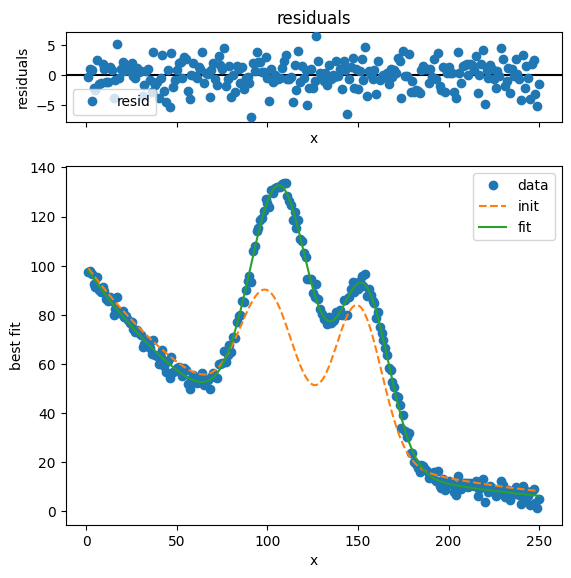

In [ ]:
# import os
# import numpy as np
# log2 = np.log(2)
# s2pi = np.sqrt(2*np.pi)
# s2 = np.sqrt(2.0)
# # tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# # here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
# tiny = 1.0e-15

# def not_zero(value):
#     """Return value with a minimal absolute size of tiny, preserving the sign.

#     This is a helper function to prevent ZeroDivisionError's.

#     Parameters
#     ----------
#     value : scalar
#         Value to be ensured not to be zero.

#     Returns
#     -------
#     scalar
#         Value ensured not to be zero.

#     """
#     return float(np.copysign(max(tiny, abs(value)), value))

# def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
#     """Return a 1-dimensional Gaussian function.

#     gaussian(x, amplitude, center, sigma) =
#         (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

#     """
#     return ((amplitude/(max(tiny, s2pi*sigma)))
#             * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


# def exponential(x, amplitude=1, decay=1):
#     """Return an exponential function.

#     exponential(x, amplitude, decay) = amplitude * exp(-x/decay)

#     """
#     decay = not_zero(decay)
#     return amplitude * np.exp(-x/decay)

# """
# # --- Here, how THEORY  function can be define
# # --- And the initial PARAMETER values
# # --- The parameter attribute definitions are:
# # value (float): Numerical Parameter value (default is 0)
# # vary (bool): Whether the Parameter is varied during a fit (default is True).
# # min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# # max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# # expr (str): Mathematical expression used to constrain the value during the fit (default is '')
# """

# theory_func_lst = [
#     {
#         'func_name': exponential,
#         'init_params' : {
#             'amplitude': {'value':100.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
#             'decay': {'value':100, },
#         },
#         'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
#     },
#     {
#         'func_name': gaussian,
#         'init_params' : {
#             'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
#             'center': {'value':100, },
#             'sigma': {'value':15, },
#         },
#         'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
#     },
#     {
#         'func_name': gaussian,
#         'init_params' : {
#             'amplitude': {'value':2000.0, 'vary':True, 'min':-np.inf, 'max':+np.inf},
#             'center': {'value':150, },
#             'sigma': {'value':13, },
#         },
#         'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
#     },
# ]

# function_block = {
#     'theory': theory_func_lst,
#     'theory_connectors': ['+', '+',],
# }

# """
# # --- The `theory_connectors` (list of str): 
#     A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
#     the theory functions listed in 'theory'. Each operator connects one function to the next 
#     in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

#     The number of connectors must be exactly one less than the number of theory functions.
#     The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
# """

# dpath='./data'  # data path

# # --- Load data (skip header) ---
# file='NIST_Gauss2.dat' # data
# file=os.path.join(
#     dpath,
#     file
# )

# dat = np.loadtxt(file)
# x = dat[:, 1]
# y = dat[:, 0]


# xy = np.column_stack([x, y])

# data_block = {
#     'xy': xy,
#     'xrange': None
#     }


# ITEMS = {
#     'data': data_block,
#     'functions': function_block,
# }

# LG = LmfitGlobal(ITEMS)


# yerr=np.ones_like(LG.data_y) * 3
# numpoints=None
# yerr=None
# # LG.plot_init(yerr=yerr, numpoints=numpoints)
# # LG.plot_dat(yerr=yerr)
# # LG.plot_init()
# LG.fit(verbose=True)
# # LG.plot_fit(yerr=yerr, show_init=True, numpoints=numpoints)
# # LG.plot_residuals()
# axes = LG.plot(yerr=yerr, show_init=True)


# LG._eval_components_per_dataset(i=0).keys()
# xfit=np.linspace(0., 300, num=1000)
# comps = LG.eval_components(x=xfit)
# LG.eval_components().keys()

# # LG.report()

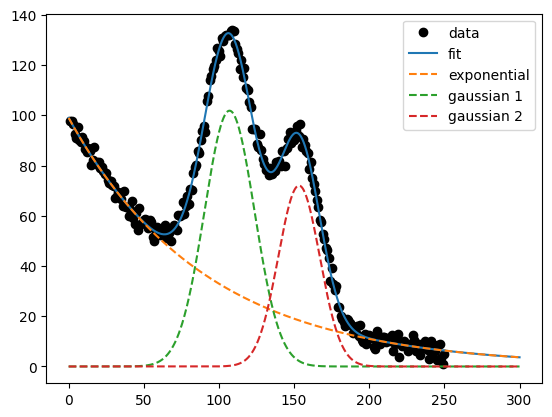

In [ ]:
# import matplotlib.pyplot as plt

# xfit=np.linspace(0., 300, num=1000)
# comps = LG.eval_components(x=xfit)
# yfit  = LG.eval(x=xfit)

# plt.plot(LG.data_x, LG.data_y, 'ko', label='data')
# plt.plot(xfit, yfit, '-', label='fit')

# plt.plot(xfit, comps['0']['c0'], '--', label='exponential')
# plt.plot(xfit, comps['0']['c1'], '--', label='gaussian 1')
# plt.plot(xfit, comps['0']['c2'], '--', label='gaussian 2')


# plt.legend()

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: #################################################
INFO: # y(x;) = gaussian(x, amplitude, center, sigma) #
INFO: #################################################
INFO: The parameter "sigma_0" is shared with ALL "sigma_*" parameters...


INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.406        0      200  0.01575     True     None     None
INFO: amplitude_1      6.99        0      200  0.01586     True     None     None
INFO: amplitude_2     7.302        0      200  0.01592     True     None     None
INFO: amplitude_3     6.015        0      200  0.01568     True     None     None
INFO: amplitude_4     9.077        0      200  0.01632     True     None     None
INFO: center_0       0.6803       -2        2 0.0008621     True     None     None
INFO: center_1       0.5045       -2        2  0.00079     True     None     None
INFO: center_2     -0.08261       -2        2 0.0007563     True     None     None
INFO: center_3      0.07383       -2        2 0.0009181     True     None     None
INFO: center_4        0.344       -2        2 0.0006083     True     None     None
INFO: sigma_0        0.2574     0.01     

dict_keys([])

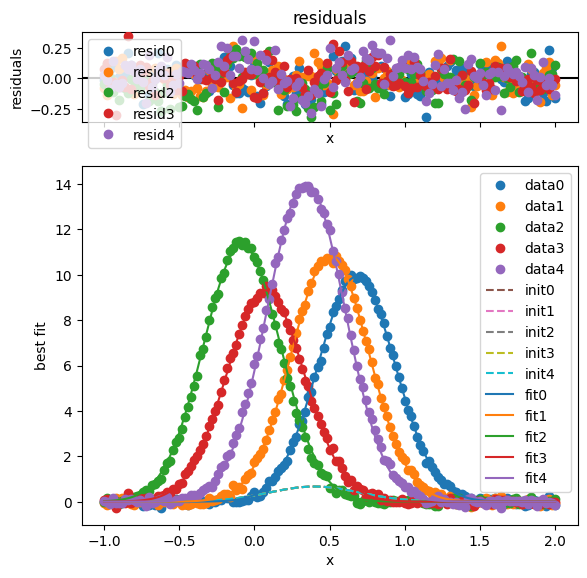

In [ ]:
# import os
# import numpy as np
# log2 = np.log(2)
# s2pi = np.sqrt(2*np.pi)
# s2 = np.sqrt(2.0)
# # tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# # here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
# tiny = 1.0e-15

# def not_zero(value):
#     """Return value with a minimal absolute size of tiny, preserving the sign.

#     This is a helper function to prevent ZeroDivisionError's.

#     Parameters
#     ----------
#     value : scalar
#         Value to be ensured not to be zero.

#     Returns
#     -------
#     scalar
#         Value ensured not to be zero.

#     """
#     return float(np.copysign(max(tiny, abs(value)), value))

# def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
#     """Return a 1-dimensional Gaussian function.

#     gaussian(x, amplitude, center, sigma) =
#         (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

#     """
#     return ((amplitude/(max(tiny, s2pi*sigma)))
#             * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


# # --- create raw data
# # number of points per dataset
# numpoints = 151
# # number of datasets
# ndata = 5

# # xy will hold x plus ndata columns of y
# xy = np.zeros((numpoints, ndata+1))

# # reproducibility
# np.random.seed(2021)

# # x grid
# x = np.linspace(-1, 2, numpoints)
# xy[:, 0] = x

# for i in range(ndata):
#     amplitude = 0.60 + 9.50*np.random.rand()
#     center = -0.20 + 1.20*np.random.rand()
#     sigma = 0.25 + 0.03*np.random.rand()

#     dat = gaussian(x, amplitude, center, sigma) \
#           + np.random.normal(scale=0.1, size=x.size)

#     xy[:, i+1] = dat



# """
# # --- Here, how THEORY  function can be define
# # --- And the initial PARAMETER values
# # --- The parameter attribute definitions are:
# # value (float): Numerical Parameter value (default is 0)
# # vary (bool): Whether the Parameter is varied during a fit (default is True).
# # min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# # max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# # expr (str): Mathematical expression used to constrain the value during the fit (default is '')
# """

# theory_func_lst = [
#     {
#         'func_name': gaussian,
#         'init_params' : {
#             'amplitude': {'value':0.5, 'vary':True, 'min':0.0, 'max':200},
#             'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
#             'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
#         },
#         'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
#     },
# ]

# function_block = {
#     'theory': theory_func_lst,
#     'theory_connectors': [],
# }

# """
# # --- The `theory_connectors` (list of str): 
#     A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
#     the theory functions listed in 'theory'. Each operator connects one function to the next 
#     in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

#     The number of connectors must be exactly one less than the number of theory functions.
#     The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
# """

# data_block = {
#     'xy': xy,
#     'xrange': None
#     }


# ITEMS = {
#     'data': data_block,
#     'functions': function_block,
# }

# LG = LmfitGlobal(ITEMS)
# par = lmfit.Parameter('sigma_0')
# # LG._set_global_params(par)
# # LG._set_global_params(['sigma_0'])
# # LG.set_global(par)
# LG.set_global(['sigma_0'])

# # LG.initial_params.pretty_print()

# yerr=np.ones_like(LG.data_y) * 3
# numpoints=None
# yerr=None
# # LG.plot_init(yerr=yerr, numpoints=numpoints)
# # LG.plot_dat(yerr=yerr)
# # LG.plot_init()
# LG.fit(verbose=True)
# # LG.plot_fit(yerr=yerr, show_init=True, numpoints=numpoints)
# # LG.plot_residuals()
# axes = LG.plot(yerr=yerr, show_init=True)


# LG._eval_components_per_dataset(i=0).keys()
# LG.eval_components()
# LG.eval_components().keys()

# # LG.report() 


INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: #################################################
INFO: # y(x;) = gaussian(x, amplitude, center, sigma) #
INFO: #################################################
INFO: Updating parameter "amplitude_0" and its attributes in "initial_params" parameters...
INFO: Updating parameter "amplitude_1" and its attributes in "initial_params" parameters...


INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0     6.361        0      200  0.01624     True     None     None
INFO: amplitude_1     6.981        0      200  0.01632     True     None     None
INFO: amplitude_2     7.217        0      200  0.01613     True     None     None
INFO: amplitude_3     6.057        0      200   0.0165     True     None     None
INFO: amplitude_4     9.175        0      200  0.01651     True     None     None
INFO: center_0       0.4152       -2        2 0.0007495     True     None     None
INFO: center_1       0.4117       -2        2 0.000693     True     None     None
INFO: center_2       0.4024       -2        2 0.0006479     True     None     None
INFO: center_3       0.4035       -2        2 0.0008252     True     None     None
INFO: center_4         0.41       -2        2 0.0005457     True     None     None
INFO: sigma_0        0.2543     0.01     

dict_keys([])

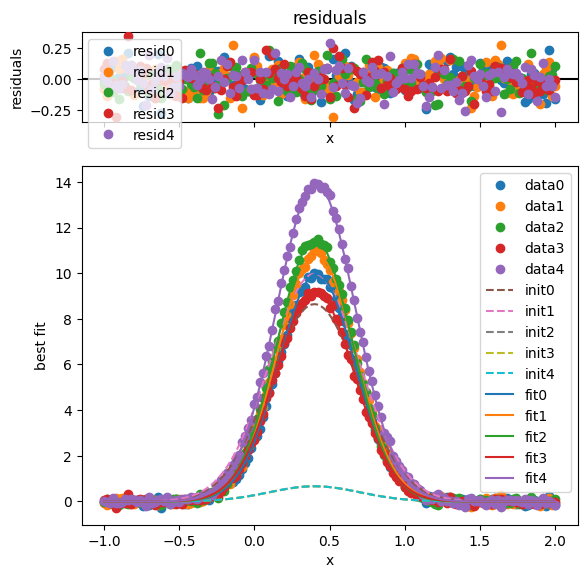

In [8]:
import os
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))

def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


# --- create raw data
# number of points per dataset
numpoints = 151
# number of datasets
ndata = 5

# xy will hold x plus ndata columns of y
xy = np.zeros((numpoints, ndata+1))

# reproducibility
np.random.seed(2021)

# x grid
x = np.linspace(-1, 2, numpoints)
xy[:, 0] = x

for i in range(ndata):
    amplitude = 0.60 + 9.50*np.random.rand()
    center = 0.40 + 0.02*np.random.rand()
    sigma = 0.25 + 0.03*np.random.rand()

    dat = gaussian(x, amplitude, center, sigma) \
          + np.random.normal(scale=0.1, size=x.size)

    xy[:, i+1] = dat



"""
# --- Here, how THEORY  function can be define
# --- And the initial PARAMETER values
# --- The parameter attribute definitions are:
# value (float): Numerical Parameter value (default is 0)
# vary (bool): Whether the Parameter is varied during a fit (default is True).
# min (float): Lower bound for value (default is -numpy.inf, no lower bound).
# max (float): Upper bound for value (default is +numpy.inf, no upper bound).
# expr (str): Mathematical expression used to constrain the value during the fit (default is '')
"""

theory_func_lst = [
    {
        'func_name': gaussian,
        'init_params' : {
            'amplitude': {'value':0.5, 'vary':True, 'min':0.0, 'max':200},
            'center': {'value':0.4, 'vary':True, 'min':-2.0, 'max':2.0},
            'sigma': {'value':0.3, 'vary':True, 'min':0.01, 'max':3.0},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

function_block = {
    'theory': theory_func_lst,
    'theory_connectors': [],
}

"""
# --- The `theory_connectors` (list of str): 
    A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
    the theory functions listed in 'theory'. Each operator connects one function to the next 
    in left-to-right order. For example, ['+', '*'] means: theory[0] + theory[1] * theory[2].

    The number of connectors must be exactly one less than the number of theory functions.
    The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
"""

data_block = {
    'xy': xy,
    'xrange': None
    }


ITEMS = {
    'data': data_block,
    'functions': function_block,
}

LG = LmfitGlobal(ITEMS)
cen = lmfit.Parameter('center_0')
sig = lmfit.Parameter('sigma_0')
params = lmfit.Parameters()
params.add("center_0")
params.add("sigma_0")
# LG._set_global_params(cen)
# LG._set_global_params(sig)
# LG._set_global_params(cen, sig)
# LG._set_global_params('sigma_0')
# LG._set_global_params(['sigma_0'])
# LG._set_global_params(['sigma_0', 'center_0'])
# LG._set_global_params(['amp_0'])   # TESTING ERROR IF PARAMETER IS WRONG
# LG.set_global(cen)
# LG.set_global(sig)
# LG.set_global(cen, sig)
# LG.set_global(['center_0', 'sigma_0'])
# LG.set_global(params)
# LG.set_global(list(params.keys()))

parameters = lmfit.Parameters()
parameters.add('amplitude_0', value=6.5)
amp0 = lmfit.Parameter('amplitude_0', value=6.5)
# amp0 = lmfit.Parameter('amplitude_0', value=7.5, min=0, max=200, vary=True)
amp1 = lmfit.Parameter('amplitude_1', value=7.5, )
# amp1 = lmfit.Parameter('amplitude_1', value=7.5, min=0, max=200, vary=True)
amp2 = lmfit.Parameter('amplitude_2', value=7.5, min=0, max=100, vary=True)
amp3 = ('amplitude_3', 10, True, None, None, None, None)
# amp4 = ('amplitude_4', )  # ERROR AS WE EXPECT MORETHAN ONE PARAMETER (NAME, VALUE, VARY, MIN, MAX, EXPR, BRUTE_STEP)
amp4 = ('amplitude_4', 10, )
# LG._update_params(amp0, amp1, amp2, amp3)
# LG._update_params(amp3, amp4)
amp5 = {'name': 'amplitude_5', 'value':10}
# LG._update_params(amp5)
# LG._update_params(parameters)
LG.update_params(amp0, amp1)

# LG.initial_params.pretty_print()

yerr=np.ones_like(LG.data_y) * 3
numpoints=None
yerr=None
# LG.plot_init(yerr=yerr, numpoints=numpoints)
# LG.plot_dat(yerr=yerr)
# LG.plot_init()
LG.fit(verbose=True)
# LG.plot_fit(yerr=yerr, show_init=True, numpoints=numpoints)
# LG.plot_residuals()
axes = LG.plot(yerr=yerr, show_init=True)


LG._eval_components_per_dataset(i=0).keys()
LG.eval_components()
LG.eval_components().keys()

# LG.report() 


In [9]:

amp0
params = lmfit.Parameters()
params.add('xvar', value=0.50, min=0)
params.set(xc=2, zvar={'value':3, 'min':0})

params

parameters = lmfit.Parameters()
parameters.add('amplitude_0', value=6.5)
parameters


params = lmfit.Parameters()
params.add('xvar', value=0.50, min=0),

par  = lmfit.Parameter('amplitude_0',)
par.name, par.value, par.vary, par.min, par.max, par.expr, par.brute_step

('amplitude_0', -inf, True, -inf, inf, None, None)

In [10]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker

# def apply_ax_kws(ax, ax_kws=None):
#     """Apply axis customizations from a dictionary.

#     Args:
#         ax (matplotlib.axes.Axes): Axis object to customize.
#         ax_kws (dict, optional): Keys are method names or special strings, values are args/kwargs.
#         Examples:
#             {
#               "figsize": None,  
#               "minorticks_on": {},
#               "tick_params_major": {"which":"major","direction":"in","length":8,"width":1.0,"top":True,"right":True},
#               "tick_params_minor": {"which":"minor","direction":"in","length":4,"width":1.0,"top":True,"right":True},
#               "tick_params_xlabels": {"axis":"x","labelsize":18,"labelcolor":"k"},
#               "tick_params_ylabels": {"axis":"y","labelsize":18,"labelcolor":"k"},
#               "set_xscale": {"value":"log"},
#               "set_xlim": ([1.0,200],),
#               "axhline": {"y":0,"color":"black","linestyle":"dotted"},
#               "axvline": {"x":12,"color":"black","linestyle":"dashed"},
#               "formatter": "log_plain",
#               "spines": {"linewidth": 1.5, "color": "black"}
#             }
#     """
#     import matplotlib.ticker as ticker

#     if not ax_kws:
#         return

#     for method_name, args in ax_kws.items():
#         # --- Special case: formatter ---
#         if method_name == "formatter":
#             if args == "log_plain":
#                 ax.xaxis.set_major_formatter(ticker.LogFormatter(base=10, labelOnlyBase=False))
#             elif callable(args):
#                 ax.xaxis.set_major_formatter(args)
#             continue

#         # --- Tick params (major/minor/labels) ---
#         if method_name in ("tick_params_major", "tick_params_minor",
#                            "tick_params_xlabels", "tick_params_ylabels"):
#             ax.tick_params(**args)
#             continue

#         # --- Spines ---
#         if method_name == "spines":
#             for spine in ax.spines.values():
#                 if "linewidth" in args:
#                     spine.set_linewidth(args["linewidth"])
#                 if "color" in args:
#                     spine.set_color(args["color"])
#             continue

#         # --- Figure size ---
#         if method_name == "figsize":
#             if args is not None:  # only apply if not None
#                 fig = ax.figure
#                 fig.set_size_inches(*args)
#             continue

#         # --- Normal methods ---
#         if hasattr(ax, method_name):
#             method = getattr(ax, method_name)
#             if isinstance(args, dict):
#                 method(**args)
#             elif isinstance(args, (list, tuple)):
#                 method(*args)
#             else:
#                 method(args)


# def plot_fit_and_residual(x, y, yfit, residual, ax=None, ax_kws=None):
#     """
#     Plot fit data, simulation, and residuals.

#     Parameters
#     ----------
#     x : array-like
#         Independent variable.
#     y : array-like
#         Observed data.
#     yfit : array-like
#         Fitted/simulated data.
#     residual : array-like
#         Residuals (y - yfit).
#     ax : matplotlib.axes.Axes, optional
#         Axis to plot on. If None, a new one is created.
#     ax_kws : dict, optional
#         Dictionary of axis customizations. Keys are method names
#         (e.g. 'set_xscale', 'tick_params', 'axhline'), values are
#         dicts of keyword arguments or tuples for positional args.
#     """
#     if ax is None:
#         fig, ax = plt.subplots()

#     # --- Plot data and fit ---
#     ax.plot(x, y, 'o', label='data')
#     ax.plot(x, yfit, '-', label='fit')
#     ax.plot(x, residual, '.', label='residual')

#     ax.legend()

#     # --- Apply axis customizations ---
#     apply_ax_kws(ax, ax_kws)

#     return ax


# import numpy as np

# x = np.linspace(1, 200, 200)
# y = np.sin(x/20) + np.random.normal(0, 0.1, size=len(x))
# yfit = np.sin(x/20)
# residual = y - yfit


# ax_kws = {
#     "figsize": None,  # set figure size

#     "minorticks_on": {},

#     # Major ticks
#     "tick_params_major": {
#         "which": "major", "direction": "in", "length": 8, "width": 1.0,
#         "top": True, "right": True
#     },

#     # Minor ticks
#     "tick_params_minor": {
#         "which": "minor", "direction": "in", "length": 4, "width": 1.0,
#         "top": True, "right": True
#     },

#     # Tick label font size
#     "tick_params_xlabels": {"axis": "x", "labelsize": 18, "labelcolor": "k"},
#     "tick_params_ylabels": {"axis": "y", "labelsize": 18, "labelcolor": "k"},

#     # "set_xscale": {"value": "log"},
#     # "set_xlim": ([1.0, 300],),
#     # "set_ylim": ([-1.5, 1.5],),
#     # "axhline": {"y": 0, "color": "black", "linestyle": "dotted"},
#     # "axvline": {"x": 12, "color": "black", "linestyle": "dashed"},
#     # "formatter": "log_plain",

#     # # splines
#     # "spines": {"linewidth": 1.5, "color": "black"}  # new entry

# }

# plot_fit_and_residual(x, y, yfit, residual, ax=None, ax_kws=ax_kws)
# plt.show()